# 8. Modeling Strategies Assignment & Supervised ML
-- Chuying Tang

In this report, we will use H2O module in Python to train random forests models on a mortgage default dataset. Also, we will experiment at least two sampling methods (either under-sampling or over-sampling techniques) to increase your predictability.



# Table of Contents <a class="anchor" id="0"></a>
- <b>[1. Data Preparation](#1)</b>
- <b>[2. H2O Introduction](#2)</b>
- <b>[3. Sample Model & Metrics Functions](#3)</b>
- <b>[4. Hyper-parameter Tunning](#4)</b>
- <b>[5. Improve the models with Resampling Methods](#5)</b>
- <b>[6. Improve the models with Feature Selection](#6)</b>
- <b>[7. Conclusion](#7)</b>

       
  <p>&nbsp;</p>

In [34]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Data Preparation <a class="anchor" id="1"></a>

In [35]:
# load data
# path = '/Users/mac/Downloads/' 
# data = pd.read_csv(path + 'XYZloan_default_selected_vars.csv')  
data = pd.read_csv('XYZloan_default_selected_vars.csv')  
data.tail()

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
79995,79995,79996,79996,0,39,2,1,12,2017/5/7 13:44,android,...,15.0,8.0,864.0,684.0,1261.0,764.0,2600.0,1074.0,11.0,OPPO
79996,79996,79997,79997,0,31,1,4,12,2017/6/2 15:54,ios,...,25.0,25.0,6177.0,6177.0,6426.0,6426.0,6426.0,6426.0,6.0,IPHONE7
79997,79997,79998,79998,0,37,1,1,12,2017/7/9 8:40,android,...,14.0,13.0,1116.0,1116.0,2061.0,2061.0,2501.0,2061.0,12.0,VIVO
79998,79998,79999,79999,0,38,2,1,12,2017/5/9 10:19,android,...,5.0,2.0,25.0,0.0,498.0,343.0,514.0,343.0,6.0,XIAOMI
79999,79999,80000,80000,1,25,1,3,12,2017/4/27 18:36,h5,...,9.0,9.0,129.0,129.0,167.0,167.0,167.0,167.0,7.0,WEB


In [36]:
# split the data for modeling
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.20, random_state=42) 

In [37]:
train.shape

(64000, 89)

In [38]:
var = pd.DataFrame(train.dtypes).reset_index()
var.head()

,index,0
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [39]:
# change the colum names of var dataframe
var.columns = ['varname','dtype'] 
var.head(10)

,varname,dtype
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64
5,AP002,int64
6,AP003,int64
7,AP004,int64
8,AP005,object
9,AP006,object


In [40]:
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0,int64,Un
1,Unnamed: 0.1,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [41]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
id     1
lo     1
Name: source, dtype: int64

In [42]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [43]:
train['loan_default'].value_counts(dropna=False)

0    51662
1    12338
Name: loan_default, dtype: int64

In [44]:
class_normal = train['loan_default'].value_counts(dropna=False)[0]
class_abnormal = train['loan_default'].value_counts(dropna=False)[1]
rate = class_abnormal/(class_normal + class_abnormal)
print(rate)

0.19278125


There are 19% of data that are abnormal in this data set, which means that the data is imbalanced. We will use balance_classes in H2O to solve this problem later.

## 2. H2O Introduction <a class="anchor" id="2"></a>

In [45]:
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,10 mins 37 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,"28 days, 1 hour and 49 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_eii3cm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.087 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [47]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [48]:
target='loan_default'

## 3. Sample Model & Metrics Functions <a class="anchor" id="3"></a>

In [49]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [50]:
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

In [51]:
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v1.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         138619                 7            13           9.17          27            34            29.9667

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14796031522774672
RMSE: 0.38465609994870315
MAE: 0.2967623200938882
RMSLE: 0.2697145892760505
Mean Residual Deviance: 0.14796031522774672

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.14814993564319848
RMSE: 0.3849025014769305
MAE: 0.296882979842838
RMSLE: 0.26987607522105317
Mean Residual Deviance: 0.14814993564319848

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.296949   0.00712503  0.308968      0.293851      0.298243      0.289581      0.298103      0.300175      0.290924      0.305441      0.285788      0.298419
mean_residual_deviance  0.148161   0.00821841  0.161214      0.143425      0.152246      0.14226       0.149569      0.154964      0.138832      0.15678       0.135871      0.146448
mse                     0.148161   0.00821841  0.161214      0.143425      0.152246      0.14226       0.149569      0.154964      0.138832      0.15678       0.135871      0.146448
r2                      0.0323535  0.0148616   0.0274963     0.0235608     0.0288095     0.0223095     0.0247649     0.0397118     0.0258111     0.0706391     0.0217309     0.0387007
residual_deviance       0.148161   0.00821841  0.161214      0.143425      0.152246      0.14226       0.149569      0.154964      0.138832      0.15678       0.135871      0.146448
rmse                    0.384783   0.0106754   0.401514      0.378715      0.390187      0.377173      0.386742      0.393654      0.372602      0.395955      0.368606      0.382685
rmsle                   0.269844   0.00517202  0.279088      0.267474      0.272555      0.265747      0.271488      0.273544      0.264226      0.273438      0.261842      0.269042

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2022-10-17 16:01:06  1 min  8.749 sec  0.0                nan                  nan                  nan
     2022-10-17 16:01:06  1 min  8.768 sec  1.0                0.38595677948093415  0.29264966642146867  0.14896263562729445
     2022-10-17 16:01:06  1 min  8.787 sec  2.0                0.38906936554864574  0.2968386017135832   0.15137497120842575
     2022-10-17 16:01:06  1 min  8.804 sec  3.0                0.38579620670975057  0.2950468144324008   0.1488387131116326
     2022-10-17 16:01:06  1 min  8.824 sec  4.0                0.38511023132965444  0.2946473403544174   0.14830989027477995
     2022-10-17 16:01:06  1 min  8.844 sec  5.0                0.3863123259129776   0.29635496590965715  0.1492372131522946
     2022-10-17 16:01:06  1 min  8.862 sec  6.0                0.38668453000213093  0.2966641759892836   0.14952492574296888
     2022-10-17 16:01:06  1 min  8.880 sec  7.0                0.38687986916015255  0.29716754676744567  0.14967603316137676
     2022-10-17 16:01:06  1 min  8.898 sec  8.0                0.3870934

#### Variable Importance

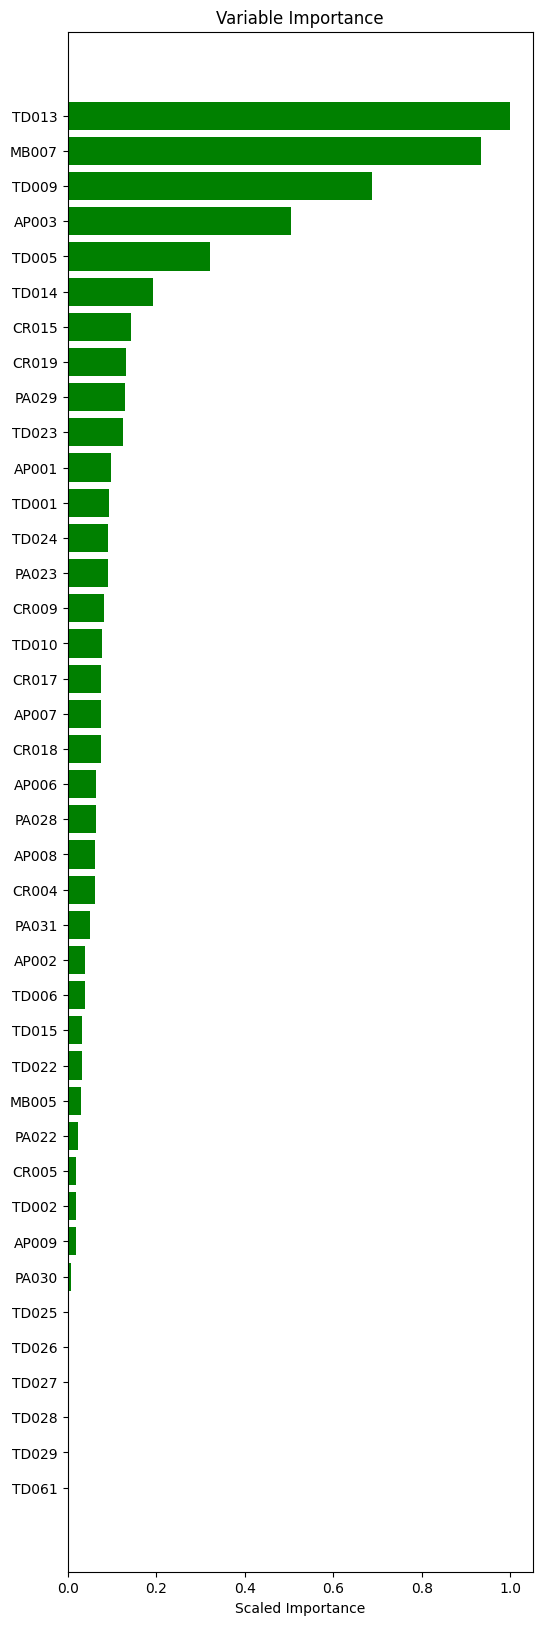

In [52]:
# define a function to visualize variable importance
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
VarImp(rf_v1)

In [53]:
predictions = rf_v1.predict(test_hex)
predictions.head()
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,loan_default,predict
0,0,0.284682
1,0,0.261607
2,0,0.214783
3,0,0.104449
4,0,0.183126


Here we define functions to generate gains table and ROC/AUC. We will first use a portion of dataset to validate that our self defined functions are application. We will then apply the functions to the whole dataset. 

### Gains Table
A Gains Chart can serve two great purposes to help our business strategies: (i) selecting the better-performing model, and (ii) deciding which segments to target. In this case, we will use it to select the better-performing model to detect the loan faults.

In [54]:
# define a function to conduct gains table
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(rf_v1)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,160,50,110,160,50,110,0.17,0.08,30.0,1.67,9.0,31.25
1,160,41,119,320,91,229,0.30,0.18,60.0,1.52,12.0,28.44
2,160,46,114,480,137,343,0.46,0.26,90.0,1.52,20.0,28.54
3,160,28,132,640,165,475,0.55,0.37,120.0,1.38,18.0,25.78
4,160,34,126,800,199,601,0.66,0.46,150.0,1.33,20.0,24.88
5,160,23,137,960,222,738,0.74,0.57,180.0,1.23,17.0,23.12
6,160,22,138,1120,244,876,0.81,0.67,210.0,1.16,14.0,21.79
7,160,26,134,1280,270,1010,0.90,0.78,240.0,1.12,12.0,21.09
8,160,16,144,1440,286,1154,0.95,0.89,270.0,1.06,6.0,19.86


### ROC (Receiver Operating Characteristic) & AUC (Area Under the Curve)
The receiver operating characteristic (ROC) curve is one of the most effective evaluation metrics because it visualizes the accuracy of predictions for a whole range of cutoff values.If we had a perfect model, the ROC curve would pass through the upper left corner — indicating no error. A better model is when the ROC is close to the upper left corner.  
The most important parameter that can be obtained from a ROC curve is the Area Under the Curve (AUC). For a perfect model, the area under the curve would be 1.0.

In [55]:
# define a functiont to calculate ROC_AUC
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



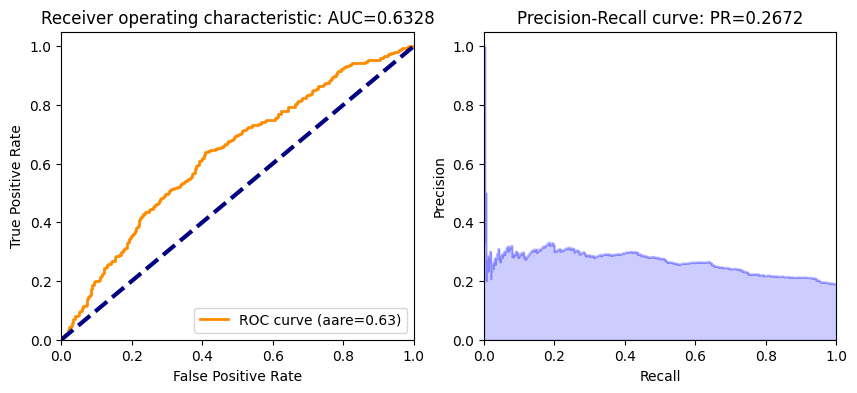

In [56]:
ROC_AUC(rf_v1,test_hex,'loan_default')

Figure above shows that the AUC is 0.6328.

#### Now the code works fine with the small dataset, we can model with the entire dataset

In [57]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

rf_v2 = H2ORandomForestEstimator(
        model_id = 'rf_v2',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v2.train(predictors,target,training_frame=train_hex)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         1.29286e+06            14           19           15.8533       289           315           303.43

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14773110691617206
RMSE: 0.38435804520807426
MAE: 0.29664612891103953
RMSLE: 0.2694420717769357
Mean Residual Deviance: 0.14773110691617206

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.14771911888095124
RMSE: 0.38434245001164163
MAE: 0.2967477145135069
RMSLE: 0.26941874944186084
Mean Residual Deviance: 0.14771911888095124

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.296762   0.00364869  0.30054       0.301814      0.298269      0.29445       0.292679      0.290095      0.298161      0.294864      0.298887      0.297859
mean_residual_deviance  0.147733   0.00356358  0.151827      0.153078      0.148761      0.145603      0.144136      0.141366      0.149009      0.145739      0.14978       0.148033
mse                     0.147733   0.00356358  0.151827      0.153078      0.148761      0.145603      0.144136      0.141366      0.149009      0.145739      0.14978       0.148033
r2                      0.0505053  0.00484609  0.050743      0.0453925     0.0569733     0.0486312     0.043897      0.054541      0.0586001     0.0486646     0.047198      0.0504118
residual_deviance       0.147733   0.00356358  0.151827      0.153078      0.148761      0.145603      0.144136      0.141366      0.149009      0.145739      0.14978       0.148033
rmse                    0.384336   0.00464263  0.38965       0.391252      0.385695      0.38158       0.379652      0.375987      0.386017      0.381757      0.387014      0.384751
rmsle                   0.269419   0.00256337  0.272212      0.273413      0.269903      0.267952      0.267093      0.264646      0.269963      0.268142      0.271074      0.269791

Scoring History: 
     timestamp            duration           number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  -----------------  -----------------  -------------------  -------------------  -------------------
     2022-10-17 16:15:23  13 min 22.921 sec  0.0                nan                  nan                  nan
     2022-10-17 16:15:23  13 min 23.158 sec  1.0                0.3931051720152581   0.2973677407074112   0.15453167626514563
     2022-10-17 16:15:23  13 min 23.412 sec  2.0                0.3932387646032997   0.2985421823954527   0.15463672598672937
     2022-10-17 16:15:23  13 min 23.636 sec  3.0                0.39102455365724004  0.2978353020880702   0.1529002015628438
     2022-10-17 16:15:24  13 min 23.891 sec  4.0                0.38977464713195054  0.29728531001168607  0.15192427554683655
     2022-10-17 16:15:24  13 min 24.125 sec  5.0                0.38931926659325905  0.29709733910764663  0.15156949134071313
     2022-10-17 16:15:24  13 min 24.351 sec  6.0                0.3884595743564522   0.2970509353003979   0.15090084090919598
     2022-10-17 16:15:24  13 min 24.604 sec  7.0                0.38798961611356536  0.2972723398355497   0.15053594221195182
     2022-10-17 16:15:25  13 min 24.827 sec  8.0           

In [58]:
createGains(rf_v2)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,619,981,1600,619,981,0.20,0.08,315.0,1.97,12.0,38.69
1,1600,484,1116,3200,1103,2097,0.35,0.16,630.0,1.75,19.0,34.47
2,1600,392,1208,4800,1495,3305,0.47,0.26,945.0,1.58,21.0,31.15
3,1600,362,1238,6400,1857,4543,0.59,0.35,1260.0,1.47,24.0,29.02
4,1600,322,1278,8000,2179,5821,0.69,0.45,1575.0,1.38,24.0,27.24
5,1600,260,1340,9600,2439,7161,0.77,0.56,1890.0,1.29,21.0,25.41
6,1600,239,1361,11200,2678,8522,0.85,0.66,2205.0,1.21,19.0,23.91
7,1600,205,1395,12800,2883,9917,0.92,0.77,2520.0,1.14,15.0,22.52
8,1600,154,1446,14400,3037,11363,0.96,0.88,2835.0,1.07,8.0,21.09


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



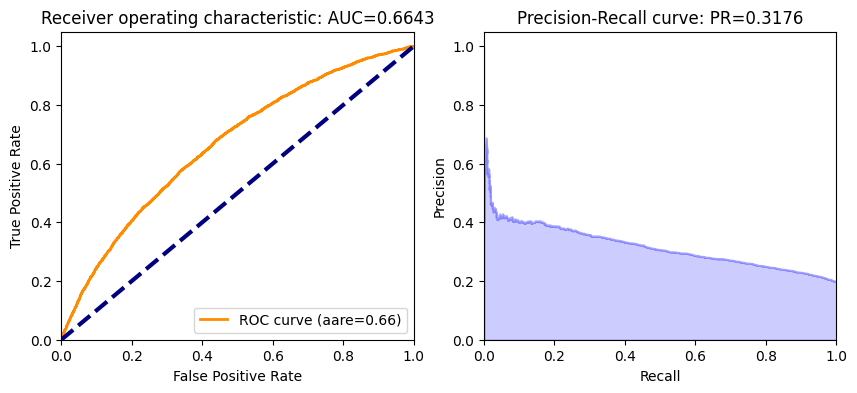

In [59]:
ROC_AUC(rf_v2,test_hex,'loan_default')

The orange curve is the ROC curve. The above plot with 0.6643 ROC means that the model result is slightly better than a completely random draw(blue line).

#### [Back to the top](#0)

## 4. Improve the model with Hyper-parameter Tunning
<a class="anchor" id="4"></a>

#### Grid Search to Tune Hyper-parameter

In [87]:
from h2o.grid.grid_search import H2OGridSearch

In [88]:
# Identify predictors and response
y_train = train[target]
X_train = train.drop(target,axis=1)

In [89]:
# convert target variable into factor for binary classification
train_hex[target] = train_hex[target].asfactor()
test_hex[target] = test_hex[target].asfactor()

In [90]:
# random forest hyperparameters
rf_params1 = {"ntrees" : [100,200,300],
              "max_depth": [5, 7, 10]}

In [91]:
grid_search_criteria = {"strategy": "RandomDiscrete", 
                        "max_models": 20, 
                        "seed": 12345}

In [92]:
# Train and validate a cartesian grid of RFs
rf_grid2 = H2OGridSearch(model=H2ORandomForestEstimator(nfolds=5,
                                                        fold_assignment="Modulo",
                                                        keep_cross_validation_predictions=True,
                                                        seed=1234), 
                          grid_id='rf_grid2',
                          hyper_params=rf_params1,
                          search_criteria=grid_search_criteria)

In [93]:
rf_grid2.train(x=predictors, y=target, training_frame=train_hex)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,max_depth,ntrees,model_ids,logloss
,10.0,300.0,rf_grid2_model_6,0.4660466
,10.0,200.0,rf_grid2_model_5,0.4661685
,10.0,100.0,rf_grid2_model_4,0.4664336
,7.0,300.0,rf_grid2_model_9,0.4684176
,7.0,200.0,rf_grid2_model_1,0.4684932
,7.0,100.0,rf_grid2_model_3,0.4686507
,5.0,300.0,rf_grid2_model_7,0.4713292
,5.0,200.0,rf_grid2_model_8,0.4714005
,5.0,100.0,rf_grid2_model_2,0.4715799


In [94]:
# Get the grid results, sorted by validation AUC
rf_gridperf2 = rf_grid2.get_grid(sort_by='auc', decreasing=True)
rf_gridperf2

,max_depth,ntrees,model_ids,auc
,10.0,300.0,rf_grid2_model_6,0.6591772
,10.0,200.0,rf_grid2_model_5,0.6588080
,10.0,100.0,rf_grid2_model_4,0.6579335
,7.0,300.0,rf_grid2_model_9,0.6544252
,7.0,200.0,rf_grid2_model_1,0.6541791
,7.0,100.0,rf_grid2_model_3,0.6535539
,5.0,300.0,rf_grid2_model_7,0.6469741
,5.0,200.0,rf_grid2_model_8,0.6467957
,5.0,100.0,rf_grid2_model_2,0.6460898


According to the ranking of auc, the best model is model6 with ntrees of 300 and max depth of 10.

In [95]:
# Grab the top RF model, chosen by validation AUC
best_rf2 = rf_gridperf2.models[0]

In [96]:
perf_best = best_rf2.model_performance(test_hex)
print(perf_best.auc())

0.6616781051201285


The best model has a AUC of 0.6617.

In [97]:
createGains(best_rf2)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,450,1150,1600,450,1150,0.14,0.09,315.0,1.43,5.0,28.12
1,1600,446,1154,3200,896,2304,0.28,0.18,630.0,1.42,10.0,28.00
2,1600,455,1145,4800,1351,3449,0.43,0.27,945.0,1.43,16.0,28.15
3,1600,428,1172,6400,1779,4621,0.56,0.36,1260.0,1.41,20.0,27.80
4,1600,320,1280,8000,2099,5901,0.67,0.46,1575.0,1.33,21.0,26.24
5,1600,210,1390,9600,2309,7291,0.73,0.57,1890.0,1.22,16.0,24.05
6,1600,207,1393,11200,2516,8684,0.80,0.68,2205.0,1.14,12.0,22.46
7,1600,230,1370,12800,2746,10054,0.87,0.78,2520.0,1.09,9.0,21.45
8,1600,224,1376,14400,2970,11430,0.94,0.89,2835.0,1.05,5.0,20.62


Conclusion:  
The 'actual' column in the gains table is not decreasing monotonically, which means our model still needs improvement.

Lift measures how much better one can expect to do with the predictive model comparing without a model. In this case, The Lift of 1.43 for fist deciles, means that when selecting 10% of the records based on the model, one can expect 1.43 times the total number of defaulted clients found by randomly selecting 10% data without a model.

## 5. Improve the models  with Resampling Methods
<a class="anchor" id="5"></a>

The dataset is imbalanced as it one of the classes, the abnormal data, constitutes only a very small minority(19%). AUC does not place more emphasis on one class over the other, so it does not reflect the minority class well.   
Therefore, we will use 'balance_classes' in H2O module and data sampling techniques to handle the imbalanced data.

### Use H2O's "balance_classes"
The balance_classes option can be used to balance the class distribution. When enabled, H2O will either undersample the majority classes or oversample the minority classes.

In [60]:
rf_v3 = H2ORandomForestEstimator(
        model_id = 'rf_v3',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        balance_classes = True,
        seed=1234)
rf_v3.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v3


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         1.29286e+06            14           19           15.8533       289           315           303.43

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14773110691617206
RMSE: 0.38435804520807426
MAE: 0.29664612891103953
RMSLE: 0.2694420717769357
Mean Residual Deviance: 0.14773110691617206

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.14771911888095124
RMSE: 0.38434245001164163
MAE: 0.2967477145135069
RMSLE: 0.26941874944186084
Mean Residual Deviance: 0.14771911888095124

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.296762   0.00364869  0.30054       0.301814      0.298269      0.29445       0.292679      0.290095      0.298161      0.294864      0.298887      0.297859
mean_residual_deviance  0.147733   0.00356358  0.151827      0.153078      0.148761      0.145603      0.144136      0.141366      0.149009      0.145739      0.14978       0.148033
mse                     0.147733   0.00356358  0.151827      0.153078      0.148761      0.145603      0.144136      0.141366      0.149009      0.145739      0.14978       0.148033
r2                      0.0505053  0.00484609  0.050743      0.0453925     0.0569733     0.0486312     0.043897      0.054541      0.0586001     0.0486646     0.047198      0.0504118
residual_deviance       0.147733   0.00356358  0.151827      0.153078      0.148761      0.145603      0.144136      0.141366      0.149009      0.145739      0.14978       0.148033
rmse                    0.384336   0.00464263  0.38965       0.391252      0.385695      0.38158       0.379652      0.375987      0.386017      0.381757      0.387014      0.384751
rmsle                   0.269419   0.00256337  0.272212      0.273413      0.269903      0.267952      0.267093      0.264646      0.269963      0.268142      0.271074      0.269791

Scoring History: 
     timestamp            duration           number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  -----------------  -----------------  -------------------  -------------------  -------------------
     2022-10-17 16:30:18  13 min 22.556 sec  0.0                nan                  nan                  nan
     2022-10-17 16:30:18  13 min 22.796 sec  1.0                0.3931051720152581   0.2973677407074112   0.15453167626514563
     2022-10-17 16:30:18  13 min 23.032 sec  2.0                0.3932387646032997   0.2985421823954527   0.15463672598672937
     2022-10-17 16:30:19  13 min 23.272 sec  3.0                0.39102455365724004  0.2978353020880702   0.1529002015628438
     2022-10-17 16:30:19  13 min 23.543 sec  4.0                0.38977464713195054  0.29728531001168607  0.15192427554683655
     2022-10-17 16:30:19  13 min 23.783 sec  5.0                0.38931926659325905  0.29709733910764663  0.15156949134071313
     2022-10-17 16:30:19  13 min 24.009 sec  6.0                0.3884595743564522   0.2970509353003979   0.15090084090919598
     2022-10-17 16:30:20  13 min 24.257 sec  7.0                0.38798961611356536  0.2972723398355497   0.15053594221195182
     2022-10-17 16:30:20  13 min 24.494 sec  8.0           

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



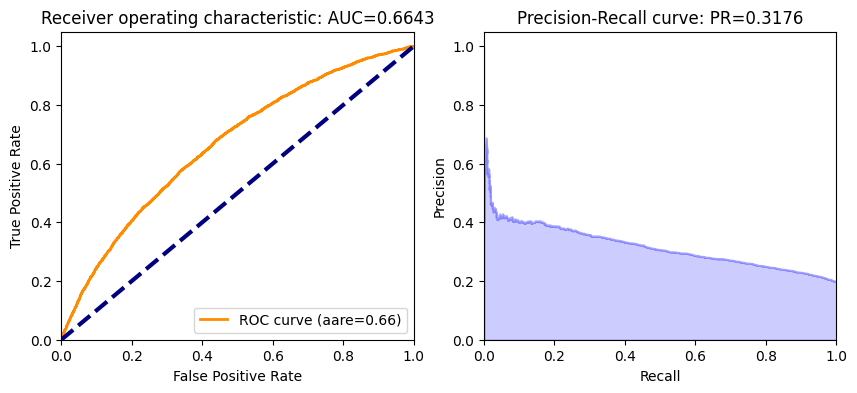

In [61]:
ROC_AUC(rf_v3,test_hex,'loan_default')

With a AUC of 0.6643, the ROC curve shows the h2o's 'balance classes' feature has little improvement to the test AUC and average precision.

In [62]:
createGains(rf_v3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,619,981,1600,619,981,0.20,0.08,315.0,1.97,12.0,38.69
1,1600,484,1116,3200,1103,2097,0.35,0.16,630.0,1.75,19.0,34.47
2,1600,392,1208,4800,1495,3305,0.47,0.26,945.0,1.58,21.0,31.15
3,1600,362,1238,6400,1857,4543,0.59,0.35,1260.0,1.47,24.0,29.02
4,1600,322,1278,8000,2179,5821,0.69,0.45,1575.0,1.38,24.0,27.24
5,1600,260,1340,9600,2439,7161,0.77,0.56,1890.0,1.29,21.0,25.41
6,1600,239,1361,11200,2678,8522,0.85,0.66,2205.0,1.21,19.0,23.91
7,1600,205,1395,12800,2883,9917,0.92,0.77,2520.0,1.14,15.0,22.52
8,1600,154,1446,14400,3037,11363,0.96,0.88,2835.0,1.07,8.0,21.09


### Undersampling
A simple under-sampling technique is to under-sample the majority class randomly and uniformly. This can potentially lead to the loss of information. But if the examples of the majority class are near to others, this method might yield good results.

In [63]:
y = data[target]
X = data.drop(target,axis=1)
y.dtypes

dtype('int64')

In [64]:
y1_cnt = data[target].sum()
y1_cnt

15488

In [65]:
N = 2
y0_cnt = y1_cnt * N
y0_cnt

30976

In [66]:
# !pip install imblearn

In [67]:
import imblearn

We will use make_imbalance function to sample from the training set.

After the sampling, we will have the number of '0' label 2 times the number of '1' label.

In [68]:
from imblearn.datasets import make_imbalance
X_rs, y_rs = make_imbalance(X, y, 
                            sampling_strategy={1:y1_cnt , 0:  y0_cnt},
                            random_state=0)
X_rs = pd.DataFrame(X_rs)
y_rs = pd.DataFrame(y_rs)  

In [69]:
y_rs = data[data[target]==1]
X_rs = data[data[target]==0].sample(n=y0_cnt)
smpl = pd.concat([X_rs,y_rs])
smpl_hex = h2o.H2OFrame(smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [70]:
rf_v4 = H2ORandomForestEstimator(
        model_id = 'rf_v4',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v4.train(predictors,target,training_frame=smpl_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v4


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         942429                 12           18           14.2667       196           230           219.947

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.20677738784193822
RMSE: 0.4547278173170608
MAE: 0.41636043350073026
RMSLE: 0.319521722755696
Mean Residual Deviance: 0.20677738784193822

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.20672584225496102
RMSE: 0.45467113637766915
MAE: 0.4165057300961766
RMSLE: 0.319473412560992
Mean Residual Deviance: 0.20672584225496102

Cross-Validation Metrics Summary: 
                        mean       sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  -----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.416515   0.00165792   0.419426      0.417376      0.417007      0.413473      0.414983      0.415224      0.416617      0.416266      0.417844      0.416932
mean_residual_deviance  0.206733   0.00163493   0.209285      0.207815      0.206257      0.203565      0.206093      0.205504      0.207151      0.20725       0.208491      0.20592
mse                     0.206733   0.00163493   0.209285      0.207815      0.206257      0.203565      0.206093      0.205504      0.207151      0.20725       0.208491      0.20592
r2                      0.0695554  0.00522482   0.0647284     0.0784637     0.0626106     0.0698844     0.0697553     0.0774618     0.0658142     0.0697268     0.0713928     0.0657162
residual_deviance       0.206733   0.00163493   0.209285      0.207815      0.206257      0.203565      0.206093      0.205504      0.207151      0.20725       0.208491      0.20592
rmse                    0.454676   0.00179893   0.457477      0.455867      0.454155      0.451182      0.453974      0.453325      0.455138      0.455247      0.456608      0.453784
rmsle                   0.319476   0.000886303  0.320925      0.318829      0.320297      0.318158      0.319302      0.318243      0.319927      0.319315      0.31977       0.319998

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2022-10-17 16:40:47  9 min  6.722 sec  0.0                nan                  nan                  nan
     2022-10-17 16:40:47  9 min  6.897 sec  1.0                0.46486651240012966  0.41714511322082265  0.2161008743510599
     2022-10-17 16:40:47  9 min  7.075 sec  2.0                0.4625577693787408   0.4157884788704973   0.2139596900126364
     2022-10-17 16:40:48  9 min  7.248 sec  3.0                0.4607704104980873   0.4153201326405094   0.2123093711905759
     2022-10-17 16:40:48  9 min  7.426 sec  4.0                0.4603610776726994   0.4156167509853832   0.21193232183596916
     2022-10-17 16:40:48  9 min  7.593 sec  5.0                0.45963797363641734  0.41578750347306453  0.21126706680859186
     2022-10-17 16:40:48  9 min  7.769 sec  6.0                0.45927162325707244  0.41621485616779735  0.21093042392918626
     2022-10-17 16:40:48  9 min  7.943 sec  7.0                0.4586942938577569   0.4161765263984221   0.21040045521766626
     2022-10-17 16:40:48  9 min  8.111 sec  8.0                0.458

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



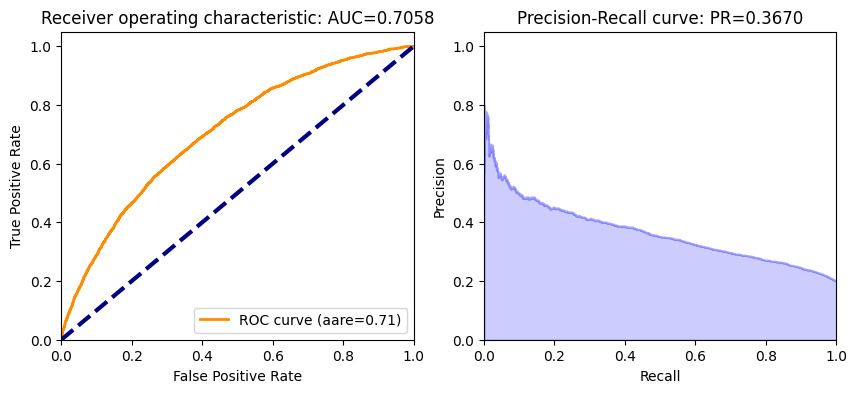

In [71]:
ROC_AUC(rf_v4,test_hex,'loan_default')

The AUC is now 0.7058 and the precision recall is 0.3670 after undersampling, which is better than the original model.

In [72]:
createGains(rf_v4)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,707,893,1600,707,893,0.22,0.07,315.0,2.24,15.0,44.19
1,1600,530,1070,3200,1237,1963,0.39,0.15,630.0,1.96,24.0,38.66
2,1600,426,1174,4800,1663,3137,0.53,0.24,945.0,1.76,29.0,34.65
3,1600,340,1260,6400,2003,4397,0.64,0.34,1260.0,1.59,30.0,31.30
4,1600,300,1300,8000,2303,5697,0.73,0.44,1575.0,1.46,29.0,28.79
5,1600,264,1336,9600,2567,7033,0.81,0.55,1890.0,1.36,26.0,26.74
6,1600,226,1374,11200,2793,8407,0.89,0.65,2205.0,1.27,24.0,24.94
7,1600,166,1434,12800,2959,9841,0.94,0.77,2520.0,1.17,17.0,23.12
8,1600,118,1482,14400,3077,11323,0.98,0.88,2835.0,1.09,10.0,21.37


#### Oversampling
Random oversampling simply replicate randomly the minority class examples. Random oversampling is known to increase the likelihood of occurring overfitting. On the other hand, the major drawback of Random undersampling is that this method can discard useful data.

In [73]:
y_train = train[target]
X_train = train.drop(target,axis=1)

In [74]:
from imblearn.over_sampling import (RandomOverSampler)
from collections import Counter

# RandomOverSampler
# With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples.
sampl2 = RandomOverSampler(sampling_strategy=0.4)
X_rs, y_rs = sampl2.fit_resample(X_train, y_train)
print('RandomOverSampler {}'.format(Counter(y_rs)))

RandomOverSampler Counter({0: 51662, 1: 20664})


Now the number of rows in class 0 has not changed and remains as 51662, while the number of rows in class 1 increase from 12338 to 20664.

In [75]:
# Combine newly created X and y 
smp2 = pd.concat([X_rs,y_rs],axis=1)
smp2_hex = h2o.H2OFrame(smp2)

# Construct new RF model
rf_v5 = H2ORandomForestEstimator(
    model_id = 'rf_v5',
    ntrees = 300,
    nfolds=10,
    min_rows=100,
    seed=1234)
rf_v5.train(predictors,target,training_frame=smp2_hex)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v5


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         1.45445e+06            14           20           16.3          330           355           342.167

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.18493858668217553
RMSE: 0.43004486589445007
MAE: 0.37746016229314905
RMSLE: 0.3017136577690691
Mean Residual Deviance: 0.18493858668217553

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.18545397265096103
RMSE: 0.43064367248452756
MAE: 0.37817084057818007
RMSLE: 0.3021544291360896
Mean Residual Deviance: 0.18545397265096103

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.378181   0.00301755  0.380788      0.381683      0.37762       0.377078      0.374938      0.373263      0.377424      0.376518      0.382749      0.379747
mean_residual_deviance  0.185464   0.00293621  0.188549      0.189175      0.184316      0.184194      0.182763      0.180946      0.184836      0.183667      0.189852      0.186345
mse                     0.185464   0.00293621  0.188549      0.189175      0.184316      0.184194      0.182763      0.180946      0.184836      0.183667      0.189852      0.186345
r2                      0.0910299  0.00406563  0.0889952     0.0863573     0.0983762     0.0924072     0.0834731     0.0920831     0.0924634     0.0925858     0.090531      0.0930265
residual_deviance       0.185464   0.00293621  0.188549      0.189175      0.184316      0.184194      0.182763      0.180946      0.184836      0.183667      0.189852      0.186345
rmse                    0.430643   0.00340659  0.434222      0.434943      0.429321      0.429178      0.427507      0.425377      0.429925      0.428563      0.435721      0.431677
rmsle                   0.302156   0.00152615  0.303629      0.304308      0.301256      0.301493      0.301153      0.299747      0.30176       0.301203      0.30434       0.302677

Scoring History: 
     timestamp            duration           number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  -----------------  -----------------  -------------------  -------------------  -------------------
     2022-10-17 16:57:26  15 min 32.253 sec  0.0                nan                  nan                  nan
     2022-10-17 16:57:26  15 min 32.521 sec  1.0                0.44272436488639455  0.37823924874711556  0.1960048632640614
     2022-10-17 16:57:26  15 min 32.804 sec  2.0                0.44168847941433936  0.3781699924842132   0.1950887128473513
     2022-10-17 16:57:27  15 min 33.069 sec  3.0                0.43915190225589185  0.3776260662730297   0.1928543932549684
     2022-10-17 16:57:27  15 min 33.347 sec  4.0                0.4379808853359308   0.37752492942135     0.19182725591964578
     2022-10-17 16:57:27  15 min 33.617 sec  5.0                0.4373332258134183   0.3778910879132424   0.19126035040037034
     2022-10-17 16:57:27  15 min 33.888 sec  6.0                0.43651584359164675  0.3782855159559688   0.19054608170652698
     2022-10-17 16:57:28  15 min 34.169 sec  7.0                0.4355319452018046   0.3781254923960234   0.18968807529126772
     2022-10-17 16:57:28  15 min 34.433 sec  8.0            

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



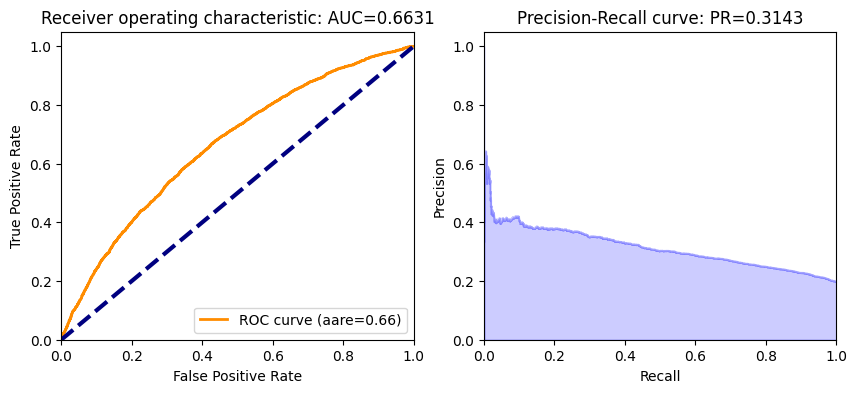

In [76]:
ROC_AUC(rf_v5,test_hex,'loan_default')

The AUC of the oversampling model is 0.6631, which is less than that of the undersampling model. It means the probability for the former model to distinguish between loan default and no default is slightly higher than this one.

In [77]:
createGains(rf_v5)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,606,994,1600,606,994,0.19,0.08,315.0,1.92,11.0,37.88
1,1600,497,1103,3200,1103,2097,0.35,0.16,630.0,1.75,19.0,34.47
2,1600,384,1216,4800,1487,3313,0.47,0.26,945.0,1.57,21.0,30.98
3,1600,372,1228,6400,1859,4541,0.59,0.35,1260.0,1.48,24.0,29.05
4,1600,318,1282,8000,2177,5823,0.69,0.45,1575.0,1.38,24.0,27.21
5,1600,261,1339,9600,2438,7162,0.77,0.56,1890.0,1.29,21.0,25.40
6,1600,245,1355,11200,2683,8517,0.85,0.66,2205.0,1.22,19.0,23.96
7,1600,203,1397,12800,2886,9914,0.92,0.77,2520.0,1.15,15.0,22.55
8,1600,153,1447,14400,3039,11361,0.96,0.88,2835.0,1.07,8.0,21.10


#### [Back to the top](#0)

## 6. Improve the model with Featrue Slection
<a class="anchor" id="6"></a>

### 6.1 Featrue Selection
We will select the 10 featrues with the highest variable importance value to improve the model. Since the undersampling model performs the best in the former models, we will build the new model on it to get better result.

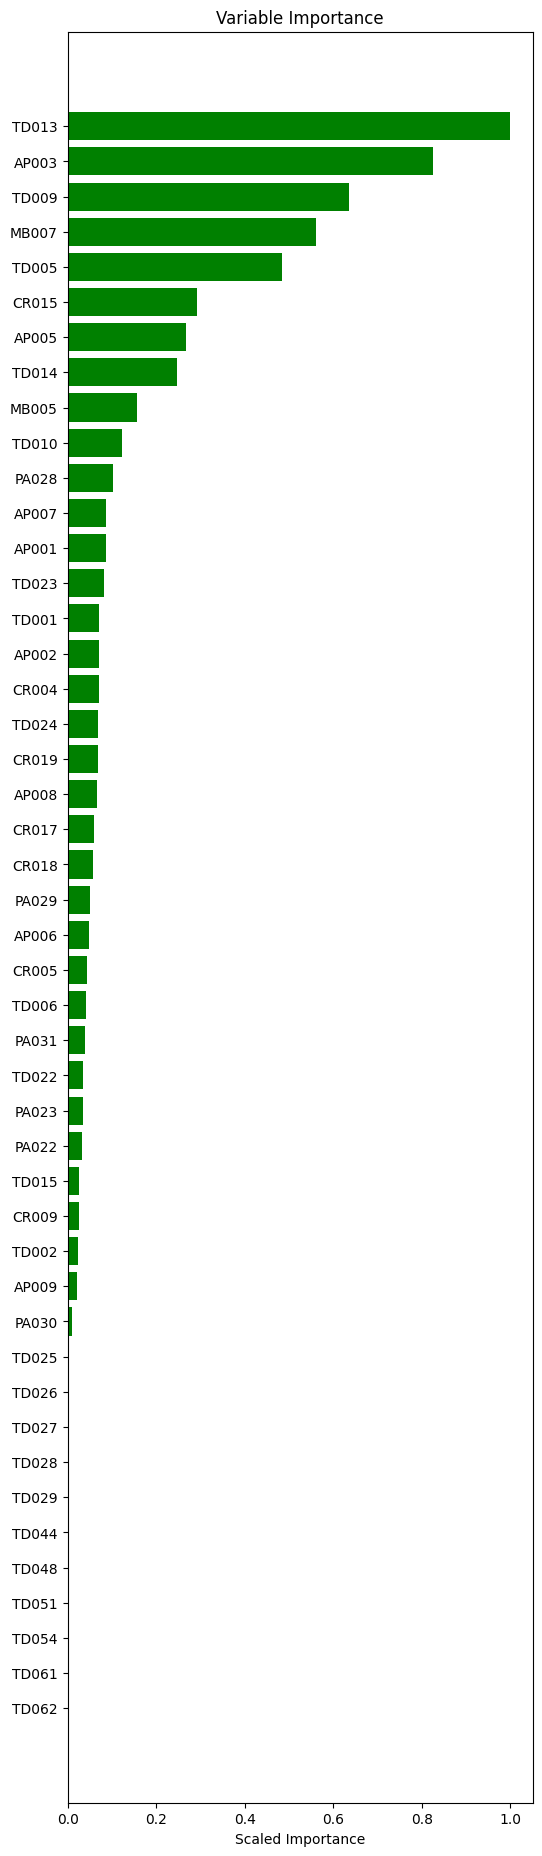

In [78]:
VarImp(rf_v4)

In [79]:
# select the 10 featrues with higher variable importance
selected_var = rf_v4._model_json['output']['variable_importances']['variable'][:10]
selected_var.append('loan_default')
selected_var

['TD013',
 'AP003',
 'TD009',
 'MB007',
 'TD005',
 'CR015',
 'AP005',
 'TD014',
 'MB005',
 'TD010',
 'loan_default']

In [80]:
train_fs = train[selected_var]
test_fs = test[selected_var]
test_fs = h2o.H2OFrame(test_fs)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [81]:
y_train = train_fs[target]
X_train = train_fs.drop(target,axis=1)

In [82]:
from imblearn.under_sampling import (RandomUnderSampler)
# RandomUnderSampler
sampler = RandomUnderSampler(sampling_strategy=0.4)
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print('Random undersampling {}'.format(Counter(y_rs)))

Random undersampling Counter({0: 30845, 1: 12338})


In [83]:
smpl3 = pd.concat([X_rs,y_rs],axis=1)
smpl3_hex = h2o.H2OFrame(smpl3)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [84]:
rf_v6 = H2ORandomForestEstimator(
        model_id = 'rf_v6',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v6.train(selected_var,target,training_frame=smpl3_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v6


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         848516                 12           18           14.2767       182           204           192.663

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.19278130038082017
RMSE: 0.4390686738778117
MAE: 0.3867427534980218
RMSLE: 0.3084474390132875
Mean Residual Deviance: 0.19278130038082017

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.19260665662275064
RMSE: 0.43886974904036236
MAE: 0.38670240007772777
RMSLE: 0.30828931680319227
Mean Residual Deviance: 0.19260665662275064

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.38671    0.00228196  0.388902      0.391004      0.384435      0.384812      0.386969      0.385208      0.38636       0.38815       0.387631      0.383632
mean_residual_deviance  0.192611   0.0026666   0.194475      0.198015      0.190441      0.190392      0.191975      0.191823      0.192687      0.194419      0.193374      0.188512
mse                     0.192611   0.0026666   0.194475      0.198015      0.190441      0.190392      0.191975      0.191823      0.192687      0.194419      0.193374      0.188512
r2                      0.0559621  0.00754602  0.0547221     0.0514342     0.0501861     0.0451307     0.0508211     0.0629906     0.0634887     0.0508979     0.0680714     0.061878
residual_deviance       0.192611   0.0026666   0.194475      0.198015      0.190441      0.190392      0.191975      0.191823      0.192687      0.194419      0.193374      0.188512
rmse                    0.438866   0.00303329  0.440993      0.444989      0.436395      0.436339      0.438149      0.437976      0.438961      0.440929      0.439743      0.43418
rmsle                   0.30829    0.00138109  0.309226      0.311007      0.307649      0.308162      0.308701      0.307113      0.30766       0.309494      0.307791      0.306093

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2022-10-17 17:03:18  4 min 22.456 sec  0.0                nan                  nan                  nan
     2022-10-17 17:03:18  4 min 22.541 sec  1.0                0.44648158021713025  0.38702297463150365  0.1993458014731857
     2022-10-17 17:03:18  4 min 22.619 sec  2.0                0.44377723838442523  0.3861546721861158   0.196938237308107
     2022-10-17 17:03:19  4 min 22.704 sec  3.0                0.44291879639055337  0.38635883491923867  0.1961770601960565
     2022-10-17 17:03:19  4 min 22.786 sec  4.0                0.4428663503608469   0.3868555732720119   0.1961306042819364
     2022-10-17 17:03:19  4 min 22.866 sec  5.0                0.4424254579111726   0.3867029755486095   0.19574028580791075
     2022-10-17 17:03:19  4 min 22.957 sec  6.0                0.44197990192766257  0.3867004023214345   0.1953462337079862
     2022-10-17 17:03:19  4 min 23.033 sec  7.0                0.44135505348940063  0.3866560424307431   0.1947942832406317
     2022-10-17 17:03:19  4 min 23.129 sec  8.0                0.441174572076

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



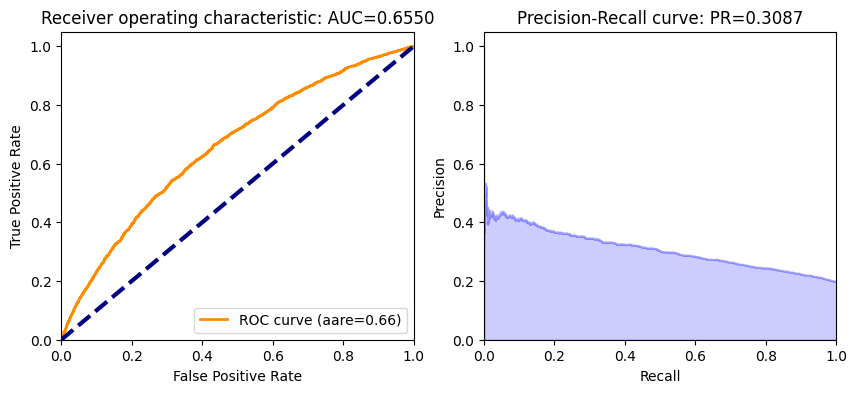

In [85]:
ROC_AUC(rf_v6,test_fs,'loan_default')

In [86]:
createGains(rf_v6)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,593,1007,1600,593,1007,0.19,0.08,315.0,1.88,11.0,37.06
1,1600,467,1133,3200,1060,2140,0.34,0.17,630.0,1.68,17.0,33.12
2,1600,438,1162,4800,1498,3302,0.48,0.26,945.0,1.59,22.0,31.21
3,1600,337,1263,6400,1835,4565,0.58,0.36,1260.0,1.46,22.0,28.67
4,1600,308,1292,8000,2143,5857,0.68,0.46,1575.0,1.36,22.0,26.79
5,1600,251,1349,9600,2394,7206,0.76,0.56,1890.0,1.27,20.0,24.94
6,1600,250,1350,11200,2644,8556,0.84,0.67,2205.0,1.20,17.0,23.61
7,1600,199,1401,12800,2843,9957,0.90,0.77,2520.0,1.13,13.0,22.21
8,1600,181,1419,14400,3024,11376,0.96,0.89,2835.0,1.07,7.0,21.00


This updated model with ten variables and undersampling indicates a better performance as the ROC reached 0.6550 and the highest lift is 1.88. The AUC is slightly higher than that of the model without feature selection(0.7058), which means that the model's predictability is not as good as expected after feature selection. The reason for the dissatisfied performance might be that the model loses some vital information when using only ten features.

## 6. Conclusion <a class="anchor" id="6"></a>
In this project, we build mutiple random forest models and use gains table, ROC, AUC to examine the model performance.
We first use grid search to tune the hyper-parameter and find out that the model performs best with 300 trees and 10 max_depth.  

We also apply oversampling and undersampling techniques to overcome the label imbalance problem. The undersampling techique works well, reaching a AUC of 0.7058 and the highest lift of 2.24. However, the models using oversampling method does not performed well as expected. The reason of it might be that our model actually overfit to the oversampling training data.  

We finally pick up top 10 features with high variable importance to build a model. But the result is not good as the former one. We need more feature engineering to improve the quality of our data.



#### [Back to the top](#0)